In [1]:
import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from scipy import ndimage

In [2]:
#class0 = good
#class1 = marginal
#class2 = other
#class3 = bad subtraction
#class4 = dark spot in template
#class5 = noisy template
#class6 = point source in template

In [3]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label = sample['image'], sample['label']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label)}

In [4]:
def TrainTest(dataset, cut, stop, value):
    
    hf = h5py.File(dataset, 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    X_train, X_test = images[0:cut], images[cut:stop]
    
    train_images_90 = np.array([ndimage.rotate(x, angle=90.0,axes=(1,2)) for x in X_train])
    train_images_180 = np.array([ndimage.rotate(x, angle=180.0,axes=(1,2)) for x in X_train])
    train_images_270 = np.array([ndimage.rotate(x, angle=270.0,axes=(1,2)) for x in X_train])
    
    
    test_images_90 = np.array([ndimage.rotate(x, angle=90.0,axes=(1,2)) for x in X_test])
    test_images_180 = np.array([ndimage.rotate(x, angle=180.0,axes=(1,2)) for x in X_test])
    test_images_270 = np.array([ndimage.rotate(x, angle=270.0,axes=(1,2)) for x in X_test])
    
    X_train = np.concatenate((X_train, train_images_90, train_images_180, train_images_270))
    X_test = np.concatenate((X_train, train_images_90, train_images_180, train_images_270))

    y_train, y_test = np.array([value] * len(X_train)), np.array([value] * len(X_test))
    
    del train_images_90,train_images_180,train_images_270
    del test_images_90,test_images_180,test_images_270
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0 = TrainTest('TS__2020-06-25_18-02-56/Class_0_images.h5',60,80,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5',160,214,0)

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
trainclass_0 = len(y_train0)
testclass_0 = len(y_test0)

X_train1, X_test1, y_train1, y_test1 = TrainTest('TS__2020-06-25_18-02-56/Class_1_images.h5',408,546,0)
trainclass_1 = len(y_train1)
testclass_1 = len(y_test1)

X_train3, X_test3, y_train3, y_test3 = TrainTest('TS__2020-06-25_18-02-56/Class_3_images.h5',408,546,1)
trainclass_3 = len(y_train3)
testclass_3 = len(y_test3)

X_train4, X_test4, y_train4, y_test4 = TrainTest('TS__2020-06-25_18-02-56/Class_4_images.h5',187,249,1)
trainclass_4 = len(y_train4)
testclass_4 = len(y_test4)

X_train5, X_test5, y_train5, y_test5 = TrainTest('TS__2020-06-25_18-02-56/Class_5_images.h5',221,297,1)
trainclass_5 = len(y_train5)
testclass_5 = len(y_test5)

X_train6, X_test6, y_train6, y_test6 = TrainTest('TS__2020-06-25_18-02-56/Class_6_images.h5',408,546,1)
trainclass_6 = len(y_train6)
testclass_6 = len(y_test6)

In [6]:
X_train, X_test = np.concatenate((X_train0,X_train1,X_train3,X_train4,X_train5,X_train6)), np.concatenate((X_test0,X_test1,X_test3,X_test4,X_test5,X_test6))
y_train, y_test = np.concatenate((y_train0,y_train1,y_train3,y_train4,y_train5,y_train6)), np.concatenate((y_test0,y_test1,y_test3,y_test4,y_test5,y_test6))

In [7]:
del X_train0,X_train1,X_train3,X_train4,X_train5,X_train6
del X_test0,X_test1,X_test3,X_test4,X_test5,X_test6
del y_train0,y_train1,y_train3,y_train4,y_train5,y_train6
del y_test0,y_test1,y_test3,y_test4,y_test5,y_test6

In [8]:
print('Class 0:',trainclass_0,testclass_0)
print('Class 1:',trainclass_1,testclass_1)
print('Class 3:',trainclass_3,testclass_3)
print('Class 4:',trainclass_4,testclass_4)
print('Class 5:',trainclass_5,testclass_5)
print('Class 6:',trainclass_6,testclass_6)

Class 0: 220 74
Class 1: 408 138
Class 3: 408 138
Class 4: 187 62
Class 5: 221 76
Class 6: 408 138


In [9]:
train0 = trainclass_0
train1 = trainclass_1 + train0
train3 = trainclass_3 + train1
train4 = trainclass_4 + train3
train5 = trainclass_5 + train4
train6 = trainclass_6 + train5

In [10]:
test0 = testclass_0
test1 = testclass_1 + test0
test3 = testclass_3 + test1
test4 = testclass_4 + test3
test5 = testclass_5 + test4
test6 = testclass_6 + test5

In [11]:
del trainclass_0,trainclass_1,trainclass_3,trainclass_4,trainclass_5,trainclass_6
del testclass_0,testclass_1,testclass_3,testclass_4,testclass_5,testclass_6

In [12]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]

In [13]:
def make_datasets(X_train, y_train, X_test, y_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [14]:
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test, y_test)

In [15]:
train_size = len(y_train)
validation_size = len(y_test)

In [16]:
del X_train,y_train,X_test,y_test

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=46656, 
                             out_features=128)
        
        self.fc2 = nn.Linear(in_features=128, 
                             out_features=2)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn = CNN()

In [18]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
number_of_training_epochs = 40

In [19]:
# Append some lists as we go to track the accuracies and loss
indices, losses, train_acc, validation_acc = [], [], [], []
index_counter = 0


for epoch in range(number_of_training_epochs):
    
    for step, batch_data in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        #Get the CNN's current prediction of the training data
        output = cnn(batch_data['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, batch_data['label']) 
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
            
        
        #Every so often, let's print out the accuracy
        if step % 100 == 0:
            
            #Evaluate the network's predictions
            train_output = cnn(train_dataset[0:train_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
            
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()
            
            #Calculate accuracy
            train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Step: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, step, train_accuracy, validation_accuracy))
            
            #save results to list for diagnostic plots
            indices.append(index_counter)
            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)
            index_counter += 1
            
            
#Evaluate the network's predictions
train_output = cnn(train_dataset[0:train_size]['image'])
validation_output = cnn(test_dataset[0:validation_size]['image'])

train_predictions = torch.max(train_output, 1)[1].data.numpy()
validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

#Calculate accuracy
train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            

Epoch: 1 Step: 0  | Training Accuracy: 0.6609071274298056 -- Validation Accuracy: 0.6613418530351438
Epoch: 2 Step: 0  | Training Accuracy: 0.6598272138228942 -- Validation Accuracy: 0.646964856230032
Epoch: 3 Step: 0  | Training Accuracy: 0.6312095032397408 -- Validation Accuracy: 0.6006389776357828
Epoch: 4 Step: 0  | Training Accuracy: 0.6614470842332614 -- Validation Accuracy: 0.6517571884984026
Epoch: 5 Step: 0  | Training Accuracy: 0.6641468682505399 -- Validation Accuracy: 0.6565495207667732
Epoch: 6 Step: 0  | Training Accuracy: 0.6684665226781857 -- Validation Accuracy: 0.6645367412140575
Epoch: 7 Step: 0  | Training Accuracy: 0.6943844492440605 -- Validation Accuracy: 0.646964856230032
Epoch: 8 Step: 0  | Training Accuracy: 0.6603671706263499 -- Validation Accuracy: 0.6533546325878594
Epoch: 9 Step: 0  | Training Accuracy: 0.693304535637149 -- Validation Accuracy: 0.6853035143769968
Epoch: 10 Step: 0  | Training Accuracy: 0.7311015118790497 -- Validation Accuracy: 0.688498402

In [20]:
predictions = validation_predictions

In [21]:
pred_class0 = predictions[np.where(test_idx <= test0)]
pred_class1 = predictions[np.where((test0 < test_idx) & (test_idx <= test1))]
pred_class3 = predictions[np.where((test1 < test_idx) & (test_idx <= test3))]
pred_class4 = predictions[np.where((test3 < test_idx) & (test_idx <= test5))]
#pred_class5 = predictions[np.where((test4 < test_idx) & (test_idx <= test5))]
pred_class6 = predictions[np.where((test5 < test_idx) & (test_idx <= test6))]

In [22]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

#pred0_class5 = (pred_class5 == 0).sum()
#pred1_class5 = (pred_class5 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

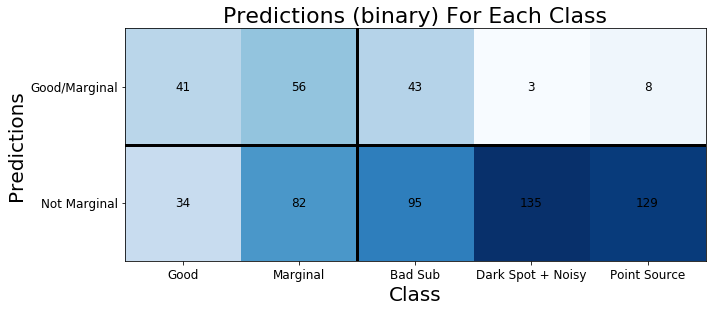

In [23]:
cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
               [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good/Marginal','Not Marginal']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(1.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()
plt.savefig('realdata_perclassmatrix.png')

In [24]:
def plot_loss_and_accuracy(indices, losses, train_acc, validation_acc, number_of_training_epochs):
    fig, (ax1) = plt.subplots(1, 1)
    
    #fit = np.poly1d(np.polyfit(indices, losses, 50))(indices)
    #ax1.plot(indices, losses, color='darkgreen', alpha=0.3)
    #ax1.plot(indices, fit, color='darkgreen', lw=2)
    #ax1.set_xlabel("Training Step", fontsize=22)
    #ax1.set_ylabel("Categorical Cross Entropy Loss", fontsize=22)
    #for ii in range(number_of_training_epochs):
    #    xval = (ii + 1) / number_of_training_epochs * np.max(indices)
    #    xval1 = (ii + 3) / number_of_training_epochs * np.max(indices)
    #    ax1.axvline(x=xval, ls='--', color='black')
    #    ax1.text(xval1 - number_of_training_epochs, 0.9, "{0}".format(ii + 1), horizontalalignment='right', fontsize=18)
    #ax1.set_ylim(0.0, 1.0)

    train_fit = np.poly1d(np.polyfit(indices, train_acc, 50))(indices)
    validation_fit = np.poly1d(np.polyfit(indices, validation_acc, 50))(indices)
    ax1.plot(indices, train_acc, alpha=0.3, color='C0')
    ax1.plot(indices, validation_acc, alpha=0.3, color='C1')
    ax1.plot(indices, train_fit, lw=2, color='C0', label="Training Data")
    ax1.plot(indices, validation_fit, lw=2, color='C1', label="Validation Data")
    ax1.legend(loc='lower right')
    ax1.set_xlabel("Training Step")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Model Accuracy')
    ax1.set_ylim(0.5,1.0)
    #for ii in range(number_of_training_epochs):
    #    xval = (ii + 1) / number_of_training_epochs * np.max(indices)
    #    xval1 = (ii + 3) / number_of_training_epochs * np.max(indices)
    #    ax2.axvline(x=xval, ls='--', color='black')
    #    ax2.text(xval1 - number_of_training_epochs, 0.82, "{0}".format(ii + 1), horizontalalignment='right', fontsize=18)
    #ax2.set_ylim(0.3, 1.0)

    fig.tight_layout()
    fig.show()
    return     

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


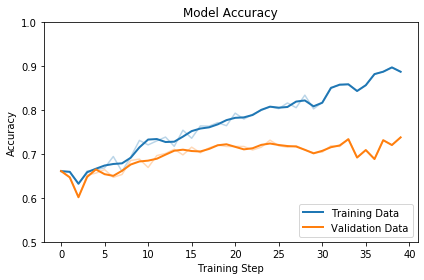

In [25]:
plot_loss_and_accuracy(indices, losses, train_acc, validation_acc, number_of_training_epochs)
plt.savefig('realdata_twoclass.png')